In [59]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

Things I could plot:
- num cells per perturbation barplot
- histogram ncounts
- histogram nGenes
- number of cells with x nperts (if it makes sense)

In [2]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
# del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
# del h5_files['PapalexiSatija2021_eccite_protein']
# del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']
print(len(h5_files))
list(h5_files.keys())

38


['PapalexiSatija2021_eccite_arrayed_protein',
 'PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_protein',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'FrangiehIzar2021_protein',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'GehringPachter2019',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'A

In [3]:
# capture obs and vars in a dict, indices as keis
obses = {}
vares = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
    vares[name] = pd.read_csv(os.path.dirname(path)+'/var.csv')

In [4]:
obses.keys()

dict_keys(['PapalexiSatija2021_eccite_arrayed_protein', 'PapalexiSatija2021_eccite_arrayed_RNA', 'PapalexiSatija2021_eccite_protein', 'PapalexiSatija2021_eccite_RNA', 'TianKampmann2021_CRISPRa', 'TianKampmann2021_CRISPRi', 'XieHon2017', 'AissaBenevolenskaya2021', 'McFarlandTshemiak2020_all_expts_combined', 'GasperiniShendure2019_lowMOI', 'GasperiniShendure2019_atscale', 'GasperiniShendure2019_highMOI', 'ZhaoSims2021', 'DixitRegev2016', 'DatlingerBock2017', 'DatlingerBock2021', 'FrangiehIzar2021_RNA', 'FrangiehIzar2021_protein', 'WeinrebKlein2020', 'ShifrutMarson2018', 'ReplogleWeissman2022_K562_essential', 'ReplogleWeissman2022_K562_gwps', 'ReplogleWeissman2022_rpe1', 'ChangYe2021', 'GehringPachter2019', 'SchiebingerLander2019_GSE115943', 'SchiebingerLander2019_GSE106340', 'NormanWeissman2019_filtered', 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen', 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen', 'AdamsonWeissman2016_GSM2406677_10X005', 'AdamsonWeissman2016_GS

In [76]:
obs = obses['SrivatsanTrapnell2020_sciplex3']

In [77]:
df = obs.value_counts('perturbation').reset_index()
df.columns = ['perturbation', 'number of cells']

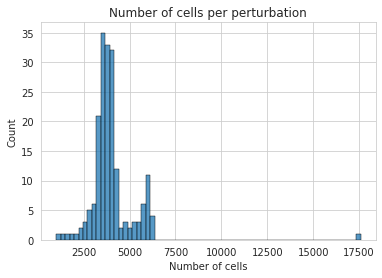

In [80]:
df = obs.value_counts('perturbation').reset_index()
df.columns = ['perturbation', 'number of cells']
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[6,4])
sns.histplot(data=df, x='number of cells')
ax.set_title('Number of cells per perturbation')
ax.set_xlabel('Number of cells')
pl.show()

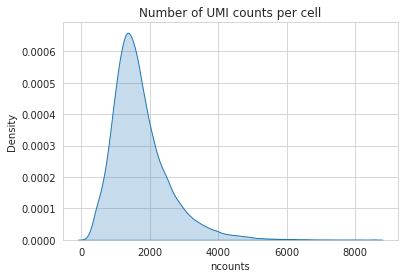

In [124]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[6,4])
df = obs.copy()
df['ncounts'] = np.clip(df['ncounts'], 0, np.percentile(df['ncounts'],99.99))
# sns.histplot(data=df, x='ncounts')
sns.kdeplot(data=df, x='ncounts', fill=True, ax=ax)
ax.set_title('Number of UMI counts per cell')
pl.show()

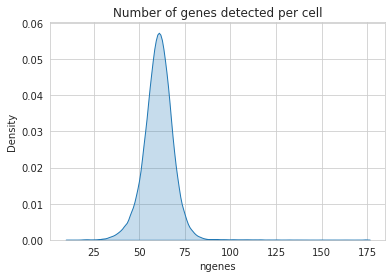

In [123]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[6,4])
df = obs.copy()
df['ngenes'] = np.clip(df['ngenes'], 0, np.percentile(df['ngenes'],99.99))
sns.kdeplot(data=df, x='ngenes', fill=True, ax=ax)
ax.set_title('Number of genes detected per cell')
pl.show()

In [128]:
ks = []
for key, obs in obses.items():
    try:
        ks.append(np.mean(obs.ncounts))
    except:
        pass

In [54]:
fig_dir = "/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/figures/website_figures/"

In [81]:
q = 0.05
for key, obs in tqdm(obses.items()):
#     if 'ncounts' in obs.columns:
#         with sns.axes_style('whitegrid'):
#             fig, ax = pl.subplots(figsize=[6,4])
#         df = obs.copy()
#         df['ncounts'] = np.clip(df['ncounts'], np.percentile(df['ncounts'], q), np.percentile(df['ncounts'], 100-q))
#         # sns.histplot(data=df, x='ncounts')
#         sns.kdeplot(data=df, x='ncounts', fill=True, ax=ax)
#         ax.set_title('Number of UMI counts per cell')
#         ax.set_yticks([])
#         pl.savefig(f'{fig_dir}ncounts_{key}.png')
#         pl.close()
    
#     if 'ngenes' in obs.columns:
#         with sns.axes_style('whitegrid'):
#             fig, ax = pl.subplots(figsize=[6,4])
#         df = obs.copy()
#         df['ngenes'] = np.clip(df['ngenes'], np.percentile(df['ngenes'], q), np.percentile(df['ngenes'], 100-q))
#         sns.kdeplot(data=df, x='ngenes', fill=True, ax=ax)
#         ax.set_title('Number of genes detected per cell')
#         ax.set_yticks([])
#         pl.savefig(f'{fig_dir}ngenes_{key}.png')
#         pl.close()
    
#     if 'nperts' in obs.columns:
#         if len(pd.unique(obs.nperts))>2:
#             obs['nperts_'] = obs.nperts.astype(str)
#             obs['nperts_'][obs.nperts>5] = '>5'
#             df = obs.nperts_.value_counts().sort_index().reset_index()
#             df.columns=['number of perturbations', 'number of cells']
#             with sns.axes_style('whitegrid'):
#                 fig, ax = pl.subplots(figsize=[6,4])
#             sns.barplot(data=df, x='number of perturbations', y='number of cells', ax=ax)
#             ax.set_title('Number of perturbations per cell')
#             pl.savefig(f'{fig_dir}nperts_{key}.png')
#             pl.close()
    
    df = obs.value_counts('perturbation').reset_index()
    df.columns = ['perturbation', 'number of cells']
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(figsize=[6,4])
    sns.histplot(data=df, x='number of cells')
    ax.set_title('Number of cells per perturbation')
    ax.set_xlabel('Number of cells')
    pl.savefig(f'{fig_dir}ncellsperpert_{key}.png')
    pl.close()


100%|██████████| 38/38 [00:33<00:00,  1.14it/s]
